# Value of disagreement in crowdsourced policymaking

In this notebook we explore the value of disagreement in crowdsourced policymaking by addressing the following research questions.

## Research Questions

1. **RQ1.** What are the predictors of disagreement?
2. **RQ2.** What are the predictors of new ideas?
3. **RQ3.** How does the presence of both disagreement and agreement affect new idea generation? (if disagreement and agreement are present simultaneously, in the same comment/thread?)
4. **RQ4.** Do comments with only disagreement/only agreement lead to more new idea generation?

## Methodology

To address RQ1 and RQ2, numeric variables computed during the qualitative analysis are considered. As the first step, we propose to conduct correlation analyses to understand collinearity between variables. Collinearity between variables might produce incorrect inferences about the association between predictors and the response variable. To address RQ1, logistic regression is employed to model the relationship between predictors and the variable disagreement. Variables that are found to be highly-correlated are not included in the analysis. In answering RQ2, multi-variate linear regression is applied to learn the relationship between predictors and the generation of new ideas. As in the case of RQ1, highly-correlated variables will be excluded from the analysis.

RQ3 is answered by fitting a logistic regression model in which the response variable is whether or not the new ideas are produced while the explanatory variables are agreement and disagreement.

For RQ4, we check the number of comments in which new ideas are produced when there is agreement or disagreement. Also, we count the number of ideas produced in comments than contain agreement and disagreement. Inferential statistics (e.g., student’s t-test) is conducted on the means of ideas produced on comments with agreement and disagreement to understand whether there is a significant difference in the number of ideas produced when agreements are present or vice versa.

## Load libraries

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

from collections import defaultdict
from predictor import predict_disagreement, get_dataset
from statsmodels.formula.api import glm, ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('seaborn')

## Load data

### Topic: Member decision making and right

In [102]:
member_df = pd.read_csv('data/member_decision_making_and_right.csv')
nrows, ncols = member_df.shape
print(f'The dataset has {nrows} rows and {ncols} columns')

The dataset has 213 rows and 51 columns


#### Columns

In [103]:
member_df.columns

Index(['Background', 'Proposals', 'Time', 'User ID', 'User email', 'User name',
       'Comment ID', 'Comment', 'Response ID', 'Response', 'Number of likes',
       'Users who liked', 'Attachments', 'Comment.1', 'Response.1', 'Topic 1',
       'Topic 2', 'Topic 3', 'disagreement', 'agreement',
       'simple disagreement', 'elaborated disagreement', 'simple agreement',
       'elaborated agreement', 'idea(s)', 'number of ideas', 'new idea',
       'sourcing', 'value(s)', 'topic shift', 'brainstorming', 'blending',
       'building', 'broadening', 'fact', 'value', 'policy', 'interpretation',
       'target of disagreement', 'target of agreement', 'gives reason(s)',
       'presents evidence', 'asks question(s)', 'provides information',
       'clarifies position/stance', 'responds to previous comment',
       'constructive tone', 'moderator post', 'acknowledges problem', 'notes',
       'annotations for disagreement / new idea cascade(s)'],
      dtype='object')

### Topic: Administration of an association

In [104]:
admin_df = pd.read_csv('data/administration_of_association.csv')
nrows, ncols = admin_df.shape
print(f'The dataset has {nrows} rows and {ncols} columns')

The dataset has 119 rows and 51 columns


#### Columns

In [105]:
admin_df.columns

Index(['Background', 'Proposal', 'Time', 'User ID', 'User email', 'User name',
       'Comment's ID', 'Comment', 'Response ID', 'Response', 'Amount of likes',
       'Users who liked', 'Attachments', 'Comment.1', 'Response.1', 'Topic 1',
       'Topic 2', 'Topic 3', 'disagreement', 'agreement',
       'simple disagreement', 'elaborated disagreement', 'simple agreement',
       'elaborated agreement', 'idea(s)', 'number of ideas', 'new idea',
       'sourcing', 'value(s)', 'topic shift', 'brainstorming', 'blending',
       'building', 'broadening', 'fact', 'value', 'policy', 'interpretation',
       'target of disagreement', 'target of agreement', 'gives reason(s)',
       'presents evidence', 'asks question(s)', 'provides information',
       'clarifies position/stance', 'responds to previous comment',
       'constructive tone', 'moderator post', 'acknowledges problem', 'notes',
       'annotations for disagreement / new idea cascades'],
      dtype='object')

### Topic: Informally organized groups of an association

In [106]:
informal_df = pd.read_csv('data/informally_organized_group_of_a.csv')
nrows, ncols = informal_df.shape
print(f'The dataset has {nrows} rows and {ncols} columns')

The dataset has 159 rows and 53 columns


#### Columns

In [107]:
informal_df.columns

Index(['Background', 'Proposal', 'Time', 'User ID', 'User email', 'User name',
       'Comment ID', 'Comment', 'Response ID', 'Response', 'Number of likes',
       'Users who liked', 'Attachments', 'Comment.1', 'Response.1', 'Topic 1',
       'Topic 2', 'Topic 3', 'disagreement', 'agreement',
       'simple disagreement', 'elaborated disagreement', 'simple agreement',
       'elaborated agreement', 'idea(s)', 'number of ideas', 'new idea',
       'sourcing', 'value(s)', 'topic shift', 'brainstorming', 'blending',
       'building', 'broadening', 'fact', 'value', 'policy', 'IRRpolicy',
       'interpretation', 'IRRinterpretation', 'target of disagreement',
       'target of agreement', 'gives reason(s)', 'presents evidence',
       'asks question(s)', 'provides information', 'clarifies position/stance',
       'responds to previous comment', 'constructive tone',
       'IRRconstructive tone', 'moderator post', 'acknowledges problem',
       'annotations for disagreement / new idea casca

## Preprocess data

### Normalize column names

Put column names to lower case, replace spaces with underscore, delete leading and trailing spaces, and remove non alpha-numerical characters

In [108]:
def normalize_column_names(names):
    names = names.str.lower()
    names = names.str.replace(' ','_')
    names = names.str.replace('.','_')
    names = names.str.replace('(','_')
    names = names.str.replace(')','')
    names = names.str.replace('/','_')
    names = names.str.replace('___','_')
    names = names.str.strip()
    return names

In [109]:
member_df.columns = normalize_column_names(member_df.columns)
admin_df.columns = normalize_column_names(admin_df.columns)
informal_df.columns = normalize_column_names(informal_df.columns)

### Standarize column names

Columns that contained the same information but have slightly different names are renamed for compatibility purposes

In [110]:
member_df = member_df.rename(columns={
    'annotations_for_disagreement_new_idea_cascade_s': 'annotations_for_disagreement_new_idea_cascades'
})

In [111]:
admin_df = admin_df.rename(columns={
    'amount_of_likes': 'number_of_likes',
    'comment\'s_id': 'comment_id',
    'proposal': 'proposals',    
})

In [112]:
informal_df = informal_df.rename(columns={
    'annotations_for_disagreement_new_idea_cascade_s': 'annotations_for_disagreement_new_idea_cascades',
    'proposal': 'proposals'
})

### Merge datasets in one dataframe

Add an extra column to indicate the discussion topic

In [113]:
member_df['topic'] = 'member'
admin_df['topic'] = 'admin'
informal_df['topic'] = 'informal'

Merge datasets

In [114]:
all_df = pd.concat([member_df, admin_df, informal_df], axis=0, ignore_index=True)

In [115]:
nrows, ncols = all_df.shape
print(f'The merged dataset has {nrows} rows and {ncols} columns')

The merged dataset has 491 rows and 55 columns


In [116]:
all_df.columns

Index(['background', 'proposals', 'time', 'user_id', 'user_email', 'user_name',
       'comment_id', 'comment', 'response_id', 'response', 'number_of_likes',
       'users_who_liked', 'attachments', 'comment_1', 'response_1', 'topic_1',
       'topic_2', 'topic_3', 'disagreement', 'agreement',
       'simple_disagreement', 'elaborated_disagreement', 'simple_agreement',
       'elaborated_agreement', 'idea_s', 'number_of_ideas', 'new_idea',
       'sourcing', 'value_s', 'topic_shift', 'brainstorming', 'blending',
       'building', 'broadening', 'fact', 'value', 'policy', 'interpretation',
       'target_of_disagreement', 'target_of_agreement', 'gives_reason_s',
       'presents_evidence', 'asks_question_s', 'provides_information',
       'clarifies_position_stance', 'responds_to_previous_comment',
       'constructive_tone', 'moderator_post', 'acknowledges_problem', 'notes',
       'annotations_for_disagreement_new_idea_cascades', 'topic', 'irrpolicy',
       'irrinterpretation', 'irrc

### Remove columns containing text in Finnish

Text of comments and responses are both in Finnish and English. Columns `comment` and `response` that contain text in Finnish are removed because they will not be considered in this analysis.

In [117]:
all_df = all_df.drop(['comment', 'response'], axis=1)

Columns `comment_1` and `response_1` are renamed removing `_1` from their names

In [118]:
all_df = all_df.rename(columns={'comment_1': 'comment', 'response_1': 'response'})

**Final columns**

In [119]:
all_df.columns

Index(['background', 'proposals', 'time', 'user_id', 'user_email', 'user_name',
       'comment_id', 'response_id', 'number_of_likes', 'users_who_liked',
       'attachments', 'comment', 'response', 'topic_1', 'topic_2', 'topic_3',
       'disagreement', 'agreement', 'simple_disagreement',
       'elaborated_disagreement', 'simple_agreement', 'elaborated_agreement',
       'idea_s', 'number_of_ideas', 'new_idea', 'sourcing', 'value_s',
       'topic_shift', 'brainstorming', 'blending', 'building', 'broadening',
       'fact', 'value', 'policy', 'interpretation', 'target_of_disagreement',
       'target_of_agreement', 'gives_reason_s', 'presents_evidence',
       'asks_question_s', 'provides_information', 'clarifies_position_stance',
       'responds_to_previous_comment', 'constructive_tone', 'moderator_post',
       'acknowledges_problem', 'notes',
       'annotations_for_disagreement_new_idea_cascades', 'topic', 'irrpolicy',
       'irrinterpretation', 'irrconstructive_tone'],
      d

### Check null values

Check the number of null values by columns

In [120]:
all_df.isnull().sum()

background                                          3
proposals                                           3
time                                                3
user_id                                             3
user_email                                          3
user_name                                           3
comment_id                                        346
response_id                                       148
number_of_likes                                     0
users_who_liked                                   263
attachments                                       491
comment                                           348
response                                          146
topic_1                                             4
topic_2                                           147
topic_3                                           358
disagreement                                        0
agreement                                           0
simple_disagreement         

### Remove summary rows

Remove rows that contain summaries. They are identified by having a null value in the column background.

In [127]:
idxs_to_remove = all_df[all_df.background.isnull()].index.values

In [128]:
all_df = all_df.drop(index=idxs_to_remove)

In [129]:
all_df.shape

(488, 53)

## RQ1. Predictors of disagreement

### Methodology

To understand which variables best predict disagreement logistic regression is applied through the following procedure:

1. Select the explanatory variables or predictors of interest (all of the available in this case). The terms predictors and variables are used interchangeable from here;
2. Cast predictors to numeric type ensuring that categorical predictors contain only binary values (1/0). Records in which categorical predictors contain values different from 0 or 1 are discarded;
3. Compute correlation between the numerical predictors number of likes and number of ideas. Because the distribution values in the numerical variables does not follow a normal distribution, the non-parametric Spearman correlation method is used. Predictors that are not independent should not be included together in logistic regression models;
4. Compute correlation between numerical and categorical variables. [Point-biserial correlation](https://www.statisticssolutions.com/point-biserial-correlation/) is used to understand the independence between categorical and numerical predictors. Predictors that are not independent should be included together in models;
5. Cast categorical predictors to category type so later the correlation between these variable can be computed;
6. Compute correlation between categorical predictors. Not independent predictors should not be included together in models;
7. Fit logistic regression models considering all possible combinations of independent predictors;
8. Select the best model and interpret the coefficients.

### 1. Define and select predictor variables for `disagreement`

In [130]:
predictors_disagreement = [
    'number_of_likes', 'number_of_ideas', 'agreement', 'simple_disagreement', 'elaborated_disagreement', 
    'topic_shift', 'brainstorming', 'blending', 'building', 'broadening', 'fact', 'value', 'policy', 
    'interpretation', 'gives_reason_s', 'presents_evidence', 'asks_question_s', 'provides_information', 
    'clarifies_position_stance', 'responds_to_previous_comment', 'constructive_tone', 'moderator_post', 
    'acknowledges_problem'
]
print(f"In total {len(predictors_disagreement)} variables will be considered in the analysis of RQ1")

In total 23 variables will be considered in the analysis of RQ1


#### Select columns that include predictors and the target variable

In [131]:
rq1_df = all_df.loc[:,predictors_disagreement+['disagreement']]
print(f"The analysis is conducted with a dataset composed of {rq1_df.shape[0]} rows and {rq1_df.shape[1]} columns")

The analysis is conducted with a dataset composed of 488 rows and 24 columns


### 2. Cast variables to numeric

Some variables have the values `unclear` and `nan`, which need to be converted to numerical before casting the variable to this type.

In [132]:
numerical_predictors = ['number_of_likes', 'number_of_ideas']

In [133]:
for col in rq1_df.columns:
    rq1_df.loc[rq1_df[col]=='unclear', col] = 0
    rq1_df.loc[rq1_df[col].isna(), col] = 0
    rq1_df[col] = pd.to_numeric(rq1_df[col], downcast='unsigned')
    if col not in numerical_predictors:
        unique_values = rq1_df[col].unique()
        invalid_values = set(unique_values) - set([0,1])
        if len(invalid_values) > 0:  # the column has invalid values                   
            invalid_indexes = list(rq1_df.loc[~rq1_df[col].isin([0,1])].index)
            if len(invalid_indexes) > 0:
                print(f'Found the following invalid values {invalid_values} in {len(invalid_indexes)} rows of '\
                      f'the column {col}. Rows has been discarded.')
                rq1_df = rq1_df.drop(index=invalid_indexes)            

/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [134]:
print(f"After the step above the dataset is composed of {rq1_df.shape[0]} rows and {rq1_df.shape[1]} columns")

After the step above the dataset is composed of 488 rows and 24 columns


#### Check variable types

In [135]:
rq1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 489
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   number_of_likes               488 non-null    uint8
 1   number_of_ideas               488 non-null    uint8
 2   agreement                     488 non-null    uint8
 3   simple_disagreement           488 non-null    uint8
 4   elaborated_disagreement       488 non-null    uint8
 5   topic_shift                   488 non-null    uint8
 6   brainstorming                 488 non-null    uint8
 7   blending                      488 non-null    uint8
 8   building                      488 non-null    uint8
 9   broadening                    488 non-null    uint8
 10  fact                          488 non-null    uint8
 11  value                         488 non-null    uint8
 12  policy                        488 non-null    uint8
 13  interpretation                488 n

### 3. Check independence between numerical variables

We use Persons correlation to find out whether the numerical variables `number_of_likes` and `number_of_ideas` are correlated.

In [136]:
alpha_level = 0.05

Distribution of `number_of_likes`

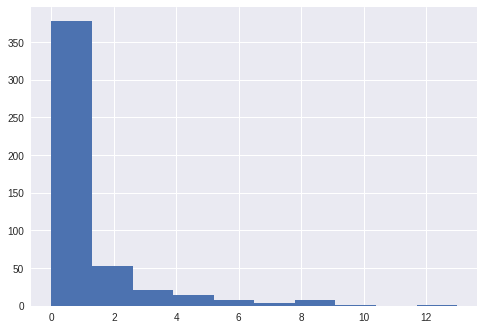

In [137]:
rq1_df['number_of_likes'].hist()

Distribution of `number_of_ideas`

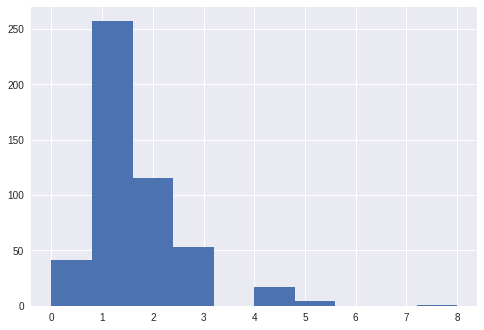

In [138]:
rq1_df['number_of_ideas'].hist()

Because data are not distributed normally, a non-parametric correlation method is used

In [139]:
correlation, p_value = stats.spearmanr(rq1_df['number_of_likes'], rq1_df['number_of_ideas'])

In [140]:
if correlation > 0.5:
    if p_val < alpha_level:
        print(f'The numerical variables are strongly and statistically significant correlated, '\
              f'corr: {round(correlation,2)}, p-value: {round(p_value,4)}.')
    else:
        print(f'The numerical variables are strongly but not statistically significant correlated, '\
              f'corr: {round(correlation,2)}, p-value: {round(p_value,4)}.')
else:
    print(f'The numerical variables are not correlated, corr: {round(correlation,2)}.')

The numerical variables are not correlated, corr: 0.11.


Numerical variables are not correlated, so they can be included together in models.

### 4. Check independence between numerical and categorical variables

Persons correlation is employed to analyze correlation between numerical and categorical variables. Having dichotomous categorical variables, Persons correlation can be used [ref](https://www.researchgate.net/post/Can_I_use_Pearsons_correlation_coefficient_to_know_the_relation_between_perception_and_gender_age_income). 

In [141]:
independence_num_cat = pd.DataFrame(columns=['number_of_likes_cor', 'number_of_likes_p_value', 
                                             'number_of_ideas_cor', 'number_of_ideas_p_value'], 
                                    index=predictors_disagreement)
for predictor_1 in numerical_predictors:    
    for predictor_2 in predictors_disagreement:        
        if predictor_2 == predictor_1:
            continue
        correlation, p_value = stats.spearmanr(rq1_df[predictor_1],rq1_df[predictor_2])
        if predictor_1 == 'number_of_likes':
            independence_num_cat.loc[predictor_2, 'number_of_likes_cor'] = round(correlation, 3)
            independence_num_cat.loc[predictor_2, 'number_of_likes_p_value'] = round(p_value, 3)
        else:
            independence_num_cat.loc[predictor_2, 'number_of_ideas_cor'] = round(correlation, 3)
            independence_num_cat.loc[predictor_2, 'number_of_ideas_p_value'] = round(p_value, 3)

In [142]:
independence_num_cat

,number_of_likes_cor,number_of_likes_p_value,number_of_ideas_cor,number_of_ideas_p_value
number_of_likes,NaN,NaN,0.114,0.011
number_of_ideas,0.114,0.011,NaN,NaN
agreement,0.105,0.021,0.094,0.039
simple_disagreement,-0.084,0.063,-0.176,0
elaborated_disagreement,-0.091,0.044,0.328,0
topic_shift,0.127,0.005,0.109,0.016
brainstorming,0.188,0,0.41,0
blending,0.094,0.037,0.251,0
building,-0.145,0.001,0.289,0
broadening,0.043,0.348,0.231,0


Numerical variables don't show to be strongly correlated with any of the categorical variables. We understand that two variables are not correlated if the correlation between them is less than 0.5.

### 5. Cast categorical variables to category type

In [144]:
for col in rq1_df.columns:
    if col not in numerical_predictors:
        rq1_df[col] = rq1_df[col].astype('category')

In [145]:
rq1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 489
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   number_of_likes               488 non-null    uint8   
 1   number_of_ideas               488 non-null    uint8   
 2   agreement                     488 non-null    category
 3   simple_disagreement           488 non-null    category
 4   elaborated_disagreement       488 non-null    category
 5   topic_shift                   488 non-null    category
 6   brainstorming                 488 non-null    category
 7   blending                      488 non-null    category
 8   building                      488 non-null    category
 9   broadening                    488 non-null    category
 10  fact                          488 non-null    category
 11  value                         488 non-null    category
 12  policy                        488 non-null    cate

### 6. Check independence of categorial variables

In [146]:
independece_analysis = pd.DataFrame(columns=predictors_disagreement, index=predictors_disagreement)
for predictor_1 in predictors_disagreement:
    if predictor_1 in numerical_predictors:
        continue
    for predictor_2 in predictors_disagreement:        
        if predictor_2 in numerical_predictors:
            continue
        if predictor_2 == predictor_1:
            continue
        cross_tab = pd.crosstab(rq1_df[predictor_1],rq1_df[predictor_2])
        chi2_stat, p_val, dof, ex = stats.chi2_contingency(cross_tab)
        if p_val < alpha_level:
            independece_analysis.loc[predictor_1,predictor_2] = 'F'
        else:
            independece_analysis.loc[predictor_1,predictor_2] = 'T'

In [147]:
independece_analysis.drop(columns=numerical_predictors, index=numerical_predictors, inplace=True)
independece_analysis

,agreement,simple_disagreement,elaborated_disagreement,topic_shift,brainstorming,blending,building,broadening,fact,value,...,interpretation,gives_reason_s,presents_evidence,asks_question_s,provides_information,clarifies_position_stance,responds_to_previous_comment,constructive_tone,moderator_post,acknowledges_problem
agreement,NaN,F,F,F,T,F,F,T,F,F,...,T,F,T,F,T,F,T,F,T,F
simple_disagreement,F,NaN,F,T,F,T,T,F,T,F,...,T,F,T,T,T,T,T,F,T,F
elaborated_disagreement,F,F,NaN,T,F,T,F,T,F,F,...,F,F,F,F,T,F,F,T,F,T
topic_shift,F,T,T,NaN,F,T,F,F,T,T,...,T,T,T,T,T,F,F,T,T,T
brainstorming,T,F,F,F,NaN,F,T,F,T,T,...,T,F,T,T,T,T,F,F,T,T
blending,F,T,T,T,F,NaN,T,T,T,F,...,T,F,T,F,T,T,F,T,T,F
building,F,T,F,F,T,T,NaN,T,F,T,...,F,F,F,F,F,F,F,T,F,T
broadening,T,F,T,F,F,T,T,NaN,T,F,...,T,F,F,T,F,T,T,T,F,F
fact,F,T,F,T,T,T,F,T,NaN,T,...,F,F,F,T,T,F,F,T,T,T
value,F,F,F,T,T,F,T,F,T,NaN,...,F,F,F,T,T,T,T,T,T,F


### 7. Fit models based on independent predictors

Based on the previous analysis of independencie between categorical variables, predictors will be selected.

In [148]:
possible_models = [None]*len(independece_analysis.columns)
idx = 0
for col in independece_analysis.columns:
    possible_models[idx] = [col]
    for row in independece_analysis.index:
        if independece_analysis.loc[row, col] == 'T':
            possible_models[idx].append(row)
    # Add the numerical variables
    for num_var in numerical_predictors:
        found_dependency = False
        for var in possible_models[idx]:
            if independence_num_cat.loc[var, f'{num_var}_cor'] > 0.5 and \
               independence_num_cat.loc[var, f'{num_var}_p_value'] < alpha_level:
                found_dependency = True
                break
        if not found_dependency:
            possible_models[idx].append(num_var)
    idx += 1

In [149]:
print(f'There are {len(possible_models)} possible models')

There are 21 possible models


Create formulas for the possible models

In [150]:
models = []
for possible_model in possible_models:
    formula = f'disagreement ~ '
    num_predictors = len(possible_model)
    for idx, predictor in enumerate(possible_model):
        if predictor not in numerical_predictors:
            formula += f' C({predictor})'
        else:
            formula += f' {predictor}'
        if idx < (len(possible_model)-1):
            formula += ' + '
    models.append({'formula': formula, 'num_predictors': num_predictors, 'predictors': possible_model})

#### Fit models

In [151]:
idx_not_fitted_models = []
for idx, model_dict in enumerate(models):
    try:
        formula = model_dict['formula']
        model = glm(formula, data = rq1_df, family = sm.families.Binomial()).fit()
        model_dict['model'] = model
        model_dict['deviance'] = model.deviance
        model_dict['log_likelihood'] = model.llf 
    except Exception as e:
        idx_not_fitted_models.append(idx)
        print(f'Error: {e}.\n\nModel:\n{formula}')
        print()

/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:894: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


Error: Perfect separation detected, results not available.

Model:
disagreement ~  C(topic_shift) +  C(simple_disagreement) +  C(elaborated_disagreement) +  C(blending) +  C(fact) +  C(value) +  C(interpretation) +  C(gives_reason_s) +  C(presents_evidence) +  C(asks_question_s) +  C(provides_information) +  C(constructive_tone) +  C(moderator_post) +  C(acknowledges_problem) +  number_of_likes +  number_of_ideas

Error: Perfect separation detected, results not available.

Model:
disagreement ~  C(blending) +  C(simple_disagreement) +  C(elaborated_disagreement) +  C(topic_shift) +  C(building) +  C(broadening) +  C(fact) +  C(interpretation) +  C(presents_evidence) +  C(provides_information) +  C(clarifies_position_stance) +  C(constructive_tone) +  C(moderator_post) +  number_of_likes +  number_of_ideas



/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:946: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:947: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:947: RuntimeWarning: invalid value encountered in add
  n * np.log(1 - mu)) * var_weights


Error: Perfect separation detected, results not available.

Model:
disagreement ~  C(provides_information) +  C(agreement) +  C(simple_disagreement) +  C(elaborated_disagreement) +  C(topic_shift) +  C(brainstorming) +  C(blending) +  C(fact) +  C(value) +  C(interpretation) +  C(presents_evidence) +  C(asks_question_s) +  C(clarifies_position_stance) +  C(responds_to_previous_comment) +  C(constructive_tone) +  C(acknowledges_problem) +  number_of_likes +  number_of_ideas



The perfect separation error happens when all values in one of the predictor categories are associated with only one of the binary outcome, see [here](https://stackoverflow.com/questions/53041669/error-perfectseparationerror-perfect-separation-detected-results-not-availab). A possible solution, which is executed below, is to drop predictors one by one and try if the resulting model can be fitted.

In [152]:
updated_models = []
for idx_not_fitted_model in idx_not_fitted_models:
    predictors = possible_models[idx_not_fitted_model].copy()
    for predictor in predictors:
        ind_vars = possible_models[idx_not_fitted_model].copy()        
        ind_vars.remove(predictor)
        formula = 'disagreement ~ '
        for idx, ind_var in enumerate(ind_vars):
            if ind_var not in numerical_predictors:
                formula += f' C({ind_var})'
            else:
                formula += f' {ind_var}'
            if idx < (len(ind_vars)-1):
                formula += ' + '
        try:
            model = glm(formula, data = rq1_df, family = sm.families.Binomial()).fit()
            print(f'Variable {predictor} has been removed from the predictors list and the model could be fitted.\n')
            updated_models.append(
                {
                    'formula': formula, 
                    'model': model, 
                    'num_predictors': len(ind_vars),
                    'predictors': ind_vars,
                    'deviance': model.deviance,
                    'log_likelihood': model.llf
                }
            )
        except:
            pass

Variable simple_disagreement has been removed from the predictors list and the model could be fitted.

Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

Variable value has been removed from the predictors list and the model could be fitted.

Variable number_of_likes has been removed from the predictors list and the model could be fitted.

Variable simple_disagreement has been removed from the predictors list and the model could be fitted.

Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

Variable building has been removed from the predictors list and the model could be fitted.

Variable simple_disagreement has been removed from the predictors list and the model could be fitted.

Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

Variable value has been removed from the predictors list and the model could be fitted.

V

In [153]:
print(f'{len(updated_models)} new models could be fitted')

11 new models could be fitted


Update list of fitted models

In [154]:
models.extend(updated_models)

### 6. Select the best model

Selection is based on the goodness of fit. `Deviance`, which is measuse of error of fit, is used to evaluate models fit. The lower the deviance the better the model fits the data. 

In [155]:
min_dev = 1000000
best_models = []
for model in models:
    if 'deviance' in model and model['deviance'] < min_dev:
        min_dev = model['deviance']
        best_models = [model]
    elif 'deviance' in model and model['deviance'] == min_dev:
        best_models.append(model)

In [156]:
print(f"There are {len(best_models)} best model(s)")

There are 1 best model(s)


**Best model**

In [157]:
best_models[0]['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Generalized Linear Model Regression Results                            
==================================================================================================
Dep. Variable:     ['disagreement[0]', 'disagreement[1]']   No. Observations:                  488
Model:                                                GLM   Df Residuals:                      473
Model Family:                                    Binomial   Df Model:                           14
Link Function:                                      logit   Scale:                          1.0000
Method:                                              IRLS   Log-Likelihood:                -54.399
Date:                                    Thu, 01 Oct 2020   Deviance:                       108.80
Time:                                            14:30:54   Pearson chi2:                     201.
No. Iterations:                                         9                                         
Covariance Type:                                nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.7289      0.788     -0.925      0.355      -2.274       0.816
C(blending)[T.1]                      0.4774      0.648      0.737      0.461      -0.792       1.747
C(elaborated_disagreement)[T.1]      -8.6447      1.443     -5.990      0.000     -11.473      -5.816
C(topic_shift)[T.1]                  -0.7351      0.735     -1.000      0.317      -2.176       0.705
C(building)[T.1]                     -3.4804      0.670     -5.198      0.000      -4.793      -2.168
C(broadening)[T.1]                    2.1644      1.343      1.612      0.107      -0.468       4.796
C(fact)[T.1]                         -0.8214      1.010     -0.814      0.416      -2.800       1.157
C(interpretation)[T.1]                0.6459      0.848      0.762      0.446      -1.015       2.307
C(presents_evidence)[T.1]            -0.2460      2.583     -0.095      0.924      -5.308       4.816
C(provides_information)[T.1]          0.9652      1.448      0.666      0.505      -1.873       3.804
C(clarifies_position_stance)[T.1]     0.9945      1.041      0.955      0.339      -1.046       3.035
C(constructive_tone)[T.1]             3.2236      0.890      3.621      0.000       1.479       4.969
C(moderator_post)[T.1]                1.0212      0.762      1.341      0.180      -0.472       2.514
number_of_likes                       0.1309      0.145      0.904      0.366      -0.153       0.415
number_of_ideas                       0.8225      0.502      1.640      0.101      -0.161       1.806
=====================================================================================================
"""

Predictors `elaborated disagreement`, `bulding`, and `constructive tone` have a statistical significant effect on `disagreement`. The rest of the predictors (i.e., fact, interpretation, asks questions, clarifies position, constructive tone, and number of likes) do not influence significantly in the presence of disagreement in discussions.

### 9. Fit a model with only the statistically significant predictors

Get the name of the predictors that have a statistically significant influence on disagreement.

In [158]:
ss_predictors = []
model_predictors = best_models[0]['model'].pvalues.index
for idx, p_value in enumerate(best_models[0]['model'].pvalues):
    if p_value < alpha_level:
        if 'C(' in model_predictors[idx]:
            predictor_name = model_predictors[idx].split('[T')[0]
        else:
            predictor_name = model_predictors[idx]
        ss_predictors.append(predictor_name)

In [159]:
formula = 'disagreement ~ '
formula += ' + '.join(ss_predictors)
best_model = glm(formula, data = rq1_df, family = sm.families.Binomial()).fit()

In [160]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Generalized Linear Model Regression Results                            
==================================================================================================
Dep. Variable:     ['disagreement[0]', 'disagreement[1]']   No. Observations:                  488
Model:                                                GLM   Df Residuals:                      484
Model Family:                                    Binomial   Df Model:                            3
Link Function:                                      logit   Scale:                          1.0000
Method:                                              IRLS   Log-Likelihood:                -63.951
Date:                                    Thu, 01 Oct 2020   Deviance:                       127.90
Time:                                            14:31:33   Pearson chi2:                     285.
No. Iterations:                                         8                                         
Covariance Type:                                nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.3394      0.749     -0.453      0.650      -1.807       1.128
C(elaborated_disagreement)[T.1]    -6.8360      1.041     -6.568      0.000      -8.876      -4.796
C(building)[T.1]                   -2.7483      0.547     -5.026      0.000      -3.820      -1.676
C(constructive_tone)[T.1]           4.0030      0.874      4.579      0.000       2.290       5.717
===================================================================================================
"""

**Interpretation of predictors' effect**

In [161]:
elaborated_disagreement = np.exp(best_model.params[1])
building = np.exp(best_model.params[2])
constructive = np.exp(best_model.params[3])

**Elaborated Disagreement**

In [162]:
print(f"The odds that disagreement appears in a discussion with elaborated disagreement are "\
      f"{round(elaborated_disagreement,4)} times the odds that disagreement appears in a "\
      f"discussion without elaborated disagreement.")

The odds that disagreement appears in a discussion with elaborated disagreement are 0.0011 times the odds that disagreement appears in a discussion without elaborated disagreement.


**Building**

In [163]:
print(f"The odds that disagreement appears in a discussion where participants build upon others' ideas "\
      f"are {round(building,4)} times the odds that disagreement appears in a discussion without building.")

The odds that disagreement appears in a discussion where participants build upon others' ideas are 0.064 times the odds that disagreement appears in a discussion without building.


**Constructive Tone**

In [164]:
print(f"The odds that disagreement appears in a discussion with constructive tone are {round(constructive,4)} " \
      f"times the estimates odds that disagreement appears in a discussion without constructive tone.")

The odds that disagreement appears in a discussion with constructive tone are 54.7644 times the estimates odds that disagreement appears in a discussion without constructive tone.


### Findings

The model that better models the presence of disagreement is composed of the variables `elaborated disagreement`, `building`, and `constructive tone`. The variables influence the presence of disagreement with different strenght. The most influencial showed to be `constructive tone`.

## RQ1. Predictors of disagreement by discussion theme

In [2]:
all_df = get_dataset()

In [3]:
predictors_disagreement = [
    'number_of_likes', 'number_of_ideas', 'agreement', 'simple_disagreement', 'elaborated_disagreement', 
    'topic_shift', 'brainstorming', 'blending', 'building', 'broadening', 'fact', 'value', 'policy', 
    'interpretation', 'gives_reason_s', 'presents_evidence', 'asks_question_s', 'provides_information', 
    'clarifies_position_stance', 'responds_to_previous_comment', 'constructive_tone', 'moderator_post', 
    'acknowledges_problem'
]

In [4]:
numerical_predictors = ['number_of_likes', 'number_of_ideas']

### Theme: Member

In [5]:
categorical_predictors = predictors_disagreement.copy()
for numerical_predictor in numerical_predictors:
    categorical_predictors.remove(numerical_predictor)

In [6]:
best_model = predict_disagreement(all_df, categorical_predictors, numerical_predictors, theme='member')

The analysis is conducted with a dataset composed of 212 rows and 24 columns
After the step above the dataset is composed of 212 rows and 24 columns


/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


There are 21 possible models


/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:894: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:946: RuntimeWarning: divide by zero encountered in true_divide
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:947: RuntimeWarning: divide by zero encountered in log
  n * np.log(1 - mu)) * var_weights
/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:947: RuntimeWarning: invalid value encountered in add
  n * np.log(1 - mu)) * var_weights


Error: Perfect separation detected, results not available.
Model:
disagreement ~  C(topic_shift) +  C(agreement) +  C(simple_disagreement) +  C(elaborated_disagreement) +  C(brainstorming) +  C(blending) +  C(building) +  C(broadening) +  C(fact) +  C(value) +  C(policy) +  C(interpretation) +  C(gives_reason_s) +  C(presents_evidence) +  C(asks_question_s) +  C(provides_information) +  C(constructive_tone) +  C(acknowledges_problem) +  number_of_likes +  number_of_ideas

Error: Perfect separation detected, results not available.
Model:
disagreement ~  C(brainstorming) +  C(agreement) +  C(simple_disagreement) +  C(elaborated_disagreement) +  C(topic_shift) +  C(blending) +  C(building) +  C(fact) +  C(value) +  C(policy) +  C(interpretation) +  C(gives_reason_s) +  C(presents_evidence) +  C(asks_question_s) +  C(provides_information) +  C(clarifies_position_stance) +  C(responds_to_previous_comment) +  C(moderator_post) +  C(acknowledges_problem) +  number_of_likes +  number_of_ideas


**Best model**

In [8]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Generalized Linear Model Regression Results                            
==================================================================================================
Dep. Variable:     ['disagreement[0]', 'disagreement[1]']   No. Observations:                  212
Model:                                                GLM   Df Residuals:                      210
Model Family:                                    Binomial   Df Model:                            1
Link Function:                                      logit   Scale:                          1.0000
Method:                                              IRLS   Log-Likelihood:                -56.977
Date:                                    Thu, 01 Oct 2020   Deviance:                       113.95
Time:                                            14:37:33   Pearson chi2:                     212.
No. Iterations:                                         6                                         
Covariance Type:                                nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.5264      0.717      4.915      0.000       2.120       4.932
C(building)[T.1]    -5.6625      0.768     -7.377      0.000      -7.167      -4.158
====================================================================================
"""

The predictor `bulding` has a statistical significant effect on `disagreement` for the theme `member`.

**Interpretation of predictors' effect**

In [9]:
best_model.params

Intercept           3.526361
C(building)[T.1]   -5.662497
dtype: float64

In [10]:
building = np.exp(best_model.params[1])

Building

In [11]:
print(f"The odds that disagreement appears in a discussion where participants build upon others' ideas "\
      f"are {round(building,3)} times the odds that disagreement appears in a discussion without building.")

The odds that disagreement appears in a discussion where participants build upon others' ideas are 0.003 times the odds that disagreement appears in a discussion without building.


### Theme: Admin

In [12]:
best_model = predict_disagreement(all_df, categorical_predictors, numerical_predictors, theme='admin')

The analysis is conducted with a dataset composed of 118 rows and 24 columns
After the step above the dataset is composed of 118 rows and 24 columns
There are 21 possible models
Error: Perfect separation detected, results not available.
Model:
disagreement ~  C(simple_disagreement) +  C(agreement) +  C(elaborated_disagreement) +  C(topic_shift) +  C(brainstorming) +  C(blending) +  C(building) +  C(broadening) +  C(fact) +  C(value) +  C(policy) +  C(interpretation) +  C(presents_evidence) +  C(asks_question_s) +  C(provides_information) +  C(clarifies_position_stance) +  C(responds_to_previous_comment) +  C(constructive_tone) +  C(moderator_post) +  C(acknowledges_problem) +  number_of_likes +  number_of_ideas

Error: Perfect separation detected, results not available.
Model:
disagreement ~  C(elaborated_disagreement) +  C(agreement) +  C(simple_disagreement) +  C(topic_shift) +  C(blending) +  C(broadening) +  C(value) +  C(interpretation) +  C(presents_evidence) +  C(asks_question_s

/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:894: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:893: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:893: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)


Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

Variable simple_disagreement has been removed from the predictors list and the model could be fitted.

Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

Variable simple_disagreement has been removed from the predictors list and the model could be fitted.

Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

Variable elaborated_disagreement has been removed from the predictors list and the model could be fitted.

Variable elaborated_disagreement has been rem

/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:946: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:946: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +


There are 1 best model(s)


**Best model**

In [13]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Generalized Linear Model Regression Results                            
==================================================================================================
Dep. Variable:     ['disagreement[0]', 'disagreement[1]']   No. Observations:                  118
Model:                                                GLM   Df Residuals:                      115
Model Family:                                    Binomial   Df Model:                            2
Link Function:                                      logit   Scale:                          1.0000
Method:                                              IRLS   Log-Likelihood:                -20.661
Date:                                    Thu, 01 Oct 2020   Deviance:                       41.322
Time:                                            14:38:13   Pearson chi2:                     117.
No. Iterations:                                         7                                         
Covariance Type:                                nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           4.4978      1.174      3.831      0.000       2.197       6.799
C(elaborated_disagreement)[T.1]    -5.5217      1.243     -4.443      0.000      -7.957      -3.086
C(building)[T.1]                   -3.5014      1.210     -2.893      0.004      -5.873      -1.129
===================================================================================================
"""

The predictors `building` have a statistical significant effect on `disagreement` for the theme `admin`.

**Interpretation of predictors' effect**

In [14]:
best_model.params

Intercept                          4.497796
C(elaborated_disagreement)[T.1]   -5.521729
C(building)[T.1]                  -3.501371
dtype: float64

In [15]:
elaborated_disagreement = np.exp(best_model.params[1])
building = np.exp(best_model.params[2])

Elaborated Disagreement

In [16]:
print(f"The odds that disagreement appears in a discussion with elaborated disagreement are "\
      f"{round(elaborated_disagreement,4)} times the odds that disagreement appears in a "\
      f"discussion without elaborated disagreement.")

The odds that disagreement appears in a discussion with elaborated disagreement are 0.004 times the odds that disagreement appears in a discussion without elaborated disagreement.


Building

In [17]:
print(f"The odds that disagreement appears in a discussion where participants build upon others' ideas "\
      f"are {round(building,4)} times the odds that disagreement appears in a discussion without building.")

The odds that disagreement appears in a discussion where participants build upon others' ideas are 0.0302 times the odds that disagreement appears in a discussion without building.


### Theme: Informal

In [18]:
best_model = predict_disagreement(all_df, categorical_predictors, numerical_predictors, theme='informal')

The analysis is conducted with a dataset composed of 158 rows and 24 columns
After the step above the dataset is composed of 158 rows and 24 columns
There are 21 possible models
Error: Perfect separation detected, results not available.
Model:
disagreement ~  C(agreement) +  C(simple_disagreement) +  C(elaborated_disagreement) +  C(brainstorming) +  C(blending) +  C(building) +  C(broadening) +  C(fact) +  C(value) +  C(interpretation) +  C(presents_evidence) +  C(provides_information) +  C(clarifies_position_stance) +  C(responds_to_previous_comment) +  C(constructive_tone) +  number_of_likes

Error: Perfect separation detected, results not available.
Model:
disagreement ~  C(topic_shift) +  C(simple_disagreement) +  C(elaborated_disagreement) +  C(brainstorming) +  C(blending) +  C(building) +  C(broadening) +  C(fact) +  C(value) +  C(interpretation) +  C(gives_reason_s) +  C(presents_evidence) +  C(asks_question_s) +  C(provides_information) +  C(clarifies_position_stance) +  C(con

**Best model**

In [19]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Generalized Linear Model Regression Results                            
==================================================================================================
Dep. Variable:     ['disagreement[0]', 'disagreement[1]']   No. Observations:                  158
Model:                                                GLM   Df Residuals:                      155
Model Family:                                    Binomial   Df Model:                            2
Link Function:                                      logit   Scale:                          1.0000
Method:                                              IRLS   Log-Likelihood:                -58.552
Date:                                    Thu, 01 Oct 2020   Deviance:                       117.10
Time:                                            14:38:59   Pearson chi2:                     164.
No. Iterations:                                         5                                         
Covariance Type:                                nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.9712      0.442      2.199      0.028       0.106       1.837
C(brainstorming)[T.1]     0.5933      0.537      1.105      0.269      -0.459       1.646
C(building)[T.1]         -3.9236      0.514     -7.636      0.000      -4.931      -2.916
=========================================================================================
"""

The predictor `building` has a statistical significant effect on `disagreement` for the theme `informal`.

**Interpretation of predictors' effect**

In [20]:
best_model.params

Intercept                0.971206
C(brainstorming)[T.1]    0.593320
C(building)[T.1]        -3.923608
dtype: float64

In [21]:
brainstorming = np.exp(best_model.params[1])
building = np.exp(best_model.params[2])

Building

In [22]:
print(f"The odds that disagreement appears in a discussion where participants build upon others' ideas "\
      f"are {round(building,4)} times the odds that disagreement appears in a discussion without building.")

The odds that disagreement appears in a discussion where participants build upon others' ideas are 0.0198 times the odds that disagreement appears in a discussion without building.


### Findings

Models are differents in each discussion theme. The presence of disagreement in the `member` theme has shown to be statistically significant affected by `building`. `Elaborated disagreement` and `building` influence statistically significant the presence of disagreement in the `admin` theme while `building` and `brainstorming` have a statistically significant effect on disagreement in the `informal` theme. 

---

## RQ2. Predictors of new ideas

### 1. Define and select predictor variables for `new ideas`

In [23]:
predictors_new_ideas = [
    'number_of_likes', 'agreement', 'disagreement', 'simple_disagreement', 'elaborated_disagreement',
    'topic_shift', 'brainstorming', 'blending', 'building', 'broadening', 'fact',
    'value', 'policy', 'interpretation', 'gives_reason_s', 'presents_evidence', 'asks_question_s',
    'provides_information', 'clarifies_position_stance', 'responds_to_previous_comment', 
    'constructive_tone', 'moderator_post', 'acknowledges_problem'
]
print(f"In total {len(predictors_new_ideas)} variables will be considered in the analysis of RQ2")

In total 23 variables will be considered in the analysis of RQ2


#### Select columns that include predictors and the target variable

In [24]:
rq2_df = all_df.loc[:,predictors_new_ideas+['number_of_ideas']]
print(f"The analysis is conducted with a dataset composed of {rq2_df.shape[0]} rows and {rq2_df.shape[1]} columns")

The analysis is conducted with a dataset composed of 488 rows and 24 columns


### 2. Cast variables to numeric

Some variables have the values `unclear` and `nan`, which need to be converted to numerical before casting the variable to this type.

In [25]:
numerical_predictors = ['number_of_likes', 'number_of_ideas']

In [26]:
for col in rq2_df.columns:
    rq2_df.loc[rq2_df[col]=='unclear', col] = 0
    rq2_df.loc[rq2_df[col].isna(), col] = 0
    rq2_df[col] = pd.to_numeric(rq2_df[col], downcast='unsigned')
    if col not in numerical_predictors:
        unique_values = rq2_df[col].unique()
        invalid_values = set(unique_values) - set([0,1])
        if len(invalid_values) > 0:  # the column has invalid values                   
            invalid_indexes = list(rq2_df.loc[~rq2_df[col].isin([0,1])].index)
            if len(invalid_indexes) > 0:
                print(f'Found the following invalid values {invalid_values} in {len(invalid_indexes)} '\
                      f'rows of the column {col}. Rows has been discarded.')
                rq2_df = rq2_df.drop(index=invalid_indexes)            

In [27]:
print(f"After the step above the dataset is composed of {rq2_df.shape[0]} rows and {rq2_df.shape[1]} columns")

After the step above the dataset is composed of 488 rows and 24 columns


### 3. Check independence between numerical and categorical variables

Persons correlation is employed to analyze correlation between numerical and categorical variables. Having dichotomous categorical variables, Persons correlation can be used [ref](https://www.researchgate.net/post/Can_I_use_Pearsons_correlation_coefficient_to_know_the_relation_between_perception_and_gender_age_income). 

In [28]:
alpha_level = 0.05

In [29]:
independence_num_cat = pd.DataFrame(columns=['number_of_likes_cor', 'number_of_likes_p_value'], 
                                    index=predictors_disagreement)
predictor_1 = 'number_of_likes'
for predictor_2 in predictors_disagreement:        
    if predictor_2 == predictor_1:
        continue
    correlation, p_value = stats.spearmanr(rq2_df[predictor_1], rq2_df[predictor_2])    
    independence_num_cat.loc[predictor_2, 'number_of_likes_cor'] = round(correlation, 3)
    independence_num_cat.loc[predictor_2, 'number_of_likes_p_value'] = round(p_value, 3)

In [30]:
independence_num_cat

,number_of_likes_cor,number_of_likes_p_value
number_of_likes,NaN,NaN
number_of_ideas,0.114,0.011
agreement,0.105,0.021
simple_disagreement,-0.084,0.063
elaborated_disagreement,-0.091,0.044
topic_shift,0.127,0.005
brainstorming,0.188,0
blending,0.094,0.037
building,-0.145,0.001
broadening,0.043,0.348


### 4. Cast categorical variables to category type

In [31]:
for col in rq2_df.columns:
    if col not in numerical_predictors:
        rq2_df[col] = rq2_df[col].astype('category')

### 5. Check independence of categorial variables

In [32]:
independece_analysis = pd.DataFrame(columns=predictors_disagreement, index=predictors_new_ideas)
for predictor_1 in predictors_disagreement:
    if predictor_1 in numerical_predictors:
        continue
    for predictor_2 in predictors_disagreement:        
        if predictor_2 in numerical_predictors:
            continue
        if predictor_2 == predictor_1:
            continue
        cross_tab = pd.crosstab(rq2_df[predictor_1], rq2_df[predictor_2])
        chi2_stat, p_val, dof, ex = stats.chi2_contingency(cross_tab)
        if p_val < alpha_level:
            independece_analysis.loc[predictor_1,predictor_2] = 'F'
        else:
            independece_analysis.loc[predictor_1,predictor_2] = 'T'

In [33]:
aux = numerical_predictors.copy()
aux.remove('number_of_ideas')
independece_analysis.drop(columns=numerical_predictors, index=aux, inplace=True)
independece_analysis

,agreement,simple_disagreement,elaborated_disagreement,topic_shift,brainstorming,blending,building,broadening,fact,value,...,interpretation,gives_reason_s,presents_evidence,asks_question_s,provides_information,clarifies_position_stance,responds_to_previous_comment,constructive_tone,moderator_post,acknowledges_problem
agreement,NaN,F,F,F,T,F,F,T,F,F,...,T,F,T,F,T,F,T,F,T,F
disagreement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
simple_disagreement,F,NaN,F,T,F,T,T,F,T,F,...,T,F,T,T,T,T,T,F,T,F
elaborated_disagreement,F,F,NaN,T,F,T,F,T,F,F,...,F,F,F,F,T,F,F,T,F,T
topic_shift,F,T,T,NaN,F,T,F,F,T,T,...,T,T,T,T,T,F,F,T,T,T
brainstorming,T,F,F,F,NaN,F,T,F,T,T,...,T,F,T,T,T,T,F,F,T,T
blending,F,T,T,T,F,NaN,T,T,T,F,...,T,F,T,F,T,T,F,T,T,F
building,F,T,F,F,T,T,NaN,T,F,T,...,F,F,F,F,F,F,F,T,F,T
broadening,T,F,T,F,F,T,T,NaN,T,F,...,T,F,F,T,F,T,T,T,F,F
fact,F,T,F,T,T,T,F,T,NaN,T,...,F,F,F,T,T,F,F,T,T,T


### 6. Fit models based on independent predictors

Based on the previous analysis of independencie between categorical variables, predictors will be selected.

In [34]:
possible_models = [None]*len(independece_analysis.columns)
idx = 0
for col in independece_analysis.columns:
    possible_models[idx] = [col]
    for row in independece_analysis.index:
        if independece_analysis.loc[row, col] == 'T':
            possible_models[idx].append(row)
    # Add the numerical variable
    possible_models[idx].append('number_of_likes')
    idx += 1

In [35]:
print(f'There are {len(possible_models)} possible models')

There are 21 possible models


Create formulas for the possible models

In [36]:
models = []
for possible_model in possible_models:
    formula = f'number_of_ideas ~ '
    num_predictors = len(possible_model)
    for idx, predictor in enumerate(possible_model):
        if predictor not in numerical_predictors:
            formula += f' C({predictor})'
        else:
            formula += f' {predictor}'
        if idx < (len(possible_model)-1):
            formula += ' + '
    models.append({'formula': formula, 'num_predictors': num_predictors, 'predictors': possible_model})

#### Fit models

In [37]:
idx_not_fitted_models = []
for idx, model_dict in enumerate(models):
    try:
        formula = model_dict['formula']
        model = ols(formula, data = rq2_df).fit()
        model_dict['model'] = model
        model_dict['r_squared'] = model.rsquared
    except Exception as e:
        idx_not_fitted_models.append(idx)
        print(f'Error: {e}.\n\nModel:\n{formula}')
        print()

In [38]:
for model in models:
    if 'agreement' in model['predictors'] or 'disagreement' in model['predictors'] or \
       'simple_disagreement' in model['predictors'] or 'elaborated_disagreement' in model['predictors']:
        print(f"- Formula: {model['formula']}\n- R^2: {model['r_squared']}")        
        model_predictors = model['model'].pvalues.index
        for idx, p_value in enumerate(model['model'].pvalues):
            if p_value < alpha_level:
                if 'agreement' in model_predictors[idx] or 'disagreement' in model_predictors[idx] or \
                   'simple_disagreement' in model_predictors[idx] or \
                   'elaborated_disagreement' in model_predictors[idx]:
                    print(f"Predictor: {model_predictors[idx]} influence statistically significant")
        print()

- Formula: number_of_ideas ~  C(agreement) +  C(brainstorming) +  C(broadening) +  C(interpretation) +  C(presents_evidence) +  C(provides_information) +  C(responds_to_previous_comment) +  C(moderator_post) +  number_of_likes
- R^2: 0.24813706048809991
Predictor: C(agreement)[T.1] influence statistically significant

- Formula: number_of_ideas ~  C(simple_disagreement) +  C(topic_shift) +  C(blending) +  C(building) +  C(fact) +  C(interpretation) +  C(presents_evidence) +  C(asks_question_s) +  C(provides_information) +  C(clarifies_position_stance) +  C(responds_to_previous_comment) +  C(moderator_post) +  number_of_likes
- R^2: 0.22020384498592227
Predictor: C(simple_disagreement)[T.1] influence statistically significant

- Formula: number_of_ideas ~  C(elaborated_disagreement) +  C(topic_shift) +  C(blending) +  C(broadening) +  C(provides_information) +  C(constructive_tone) +  C(acknowledges_problem) +  number_of_likes
- R^2: 0.22898368510401446
Predictor: C(elaborated_disagreem

### 7. Select the best model

Selection is based on the goodness of fit. `R^2` is used to evaluate models fit. The higher the R^2 the better the model fits the data. 

In [39]:
max_r2 = -100
best_models = []
for model in models:
    if 'r_squared' in model and model['r_squared'] > max_r2:
        max_r2 = model['r_squared']
        best_models = [model]
    elif 'r_squared' in model and model['r_squared'] == max_r2:
        best_models.append(model)

In [40]:
print(f"There are {len(best_models)} best model(s)")

There are 1 best model(s)


**Best model**

In [41]:
best_models[0]['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        number_of_ideas   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     13.25
Date:                Thu, 01 Oct 2020   Prob (F-statistic):           3.53e-33
Time:                        14:44:06   Log-Likelihood:                -594.22
No. Observations:                 488   AIC:                             1228.
Df Residuals:                     468   BIC:                             1312.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.5755      0.248      2.317      0.021       0.087       1.064
C(constructive_tone)[T.1]                0.0390      0.226      0.173      0.863      -0.405       0.483
C(elaborated_disagreement)[T.1]          0.0838      0.123      0.679      0.497      -0.159       0.326
C(topic_shift)[T.1]                      0.1880      0.103      1.826      0.068      -0.014       0.390
C(blending)[T.1]                         0.4129      0.091      4.535      0.000       0.234       0.592
C(building)[T.1]                         0.1320      0.124      1.062      0.289      -0.112       0.376
C(broadening)[T.1]                       0.3414      0.111      3.085      0.002       0.124       0.559
C(fact)[T.1]                            -0.1136      0.119     -0.951      0.342      -0.348       0.121
C(value)[T.1]                            0.2957      0.109      2.708      0.007       0.081       0.510
C(policy)[T.1]                          -0.0198      0.106     -0.187      0.851      -0.227       0.188
C(interpretation)[T.1]                   0.1600      0.092      1.743      0.082      -0.020       0.340
C(gives_reason_s)[T.1]                   0.6534      0.109      5.993      0.000       0.439       0.868
C(presents_evidence)[T.1]               -0.0424      0.153     -0.277      0.782      -0.343       0.259
C(asks_question_s)[T.1]                  0.4758      0.107      4.448      0.000       0.266       0.686
C(provides_information)[T.1]             0.1490      0.191      0.780      0.436      -0.226       0.524
C(clarifies_position_stance)[T.1]        0.3021      0.127      2.374      0.018       0.052       0.552
C(responds_to_previous_comment)[T.1]    -0.2220      0.112     -1.980      0.048      -0.442      -0.002
C(moderator_post)[T.1]                  -0.2768      0.097     -2.839      0.005      -0.468      -0.085
C(acknowledges_problem)[T.1]             0.2075      0.090      2.311      0.021       0.031       0.384
number_of_likes                          0.0277      0.023      1.203      0.230      -0.018       0.073
==============================================================================
Omnibus:                      183.027   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1052.631
Skew:                           1.525   Prob(JB):                    2.66e-229
Kurtosis:                       9.517   Cond. No.                         22.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 8. Fit a model with only the statistically significant predictors

Get the name of the predictors that have a statistically significant influence on disagreement.

In [42]:
ss_predictors = []
model_predictors = best_models[0]['model'].pvalues.index
for idx, p_value in enumerate(best_models[0]['model'].pvalues):
    if model_predictors[idx] == 'Intercept':
        continue
    if p_value < alpha_level:
        if 'C(' in model_predictors[idx]:
            predictor_name = model_predictors[idx].split('[T')[0]
        else:
            predictor_name = model_predictors[idx]
        ss_predictors.append(predictor_name)

In [43]:
formula = 'number_of_ideas ~ '
formula += ' + '.join(ss_predictors)
best_model = ols(formula, data = rq2_df).fit()

In [44]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        number_of_ideas   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     26.05
Date:                Thu, 01 Oct 2020   Prob (F-statistic):           1.50e-36
Time:                        14:44:18   Log-Likelihood:                -601.88
No. Observations:                 488   AIC:                             1224.
Df Residuals:                     478   BIC:                             1266.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.7775      0.111      7.009      0.000       0.560       0.996
C(blending)[T.1]                         0.4138      0.090      4.592      0.000       0.237       0.591
C(broadening)[T.1]                       0.3581      0.106      3.364      0.001       0.149       0.567
C(value)[T.1]                            0.3225      0.107      3.005      0.003       0.112       0.533
C(gives_reason_s)[T.1]                   0.7573      0.095      7.974      0.000       0.571       0.944
C(asks_question_s)[T.1]                  0.5371      0.102      5.275      0.000       0.337       0.737
C(clarifies_position_stance)[T.1]        0.3590      0.121      2.966      0.003       0.121       0.597
C(responds_to_previous_comment)[T.1]    -0.2678      0.095     -2.825      0.005      -0.454      -0.082
C(moderator_post)[T.1]                  -0.2660      0.091     -2.913      0.004      -0.445      -0.087
C(acknowledges_problem)[T.1]             0.1839      0.087      2.116      0.035       0.013       0.355
==============================================================================
Omnibus:                      162.510   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              703.556
Skew:                           1.430   Prob(JB):                    1.68e-153
Kurtosis:                       8.140   Cond. No.                         6.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 9. Interpret coefficients

#### Inspect significant coefficients

In [45]:
blending = best_model.params[1]
broadening = best_model.params[2]
value = best_model.params[3]
give_reasons = best_model.params[4]
ask_questions = best_model.params[5]
clarifies_position = best_model.params[6]
respond_to_previous_comments = best_model.params[7]
moderator_post = best_model.params[8]
acknowledge_problem = best_model.params[9]

Blending

In [46]:
print(f"Discussions where diverse ideas are integrated (blending) increase the estimate value of new ideas by "\
      f"{round(blending,3)}")

Discussions where diverse ideas are integrated (blending) increase the estimate value of new ideas by 0.414


Broadening

In [47]:
print(f"Discussions where there is diversity of perspectives (broadening) increase the estimate value of new"\
      f" ideas by {round(broadening,3)}")

Discussions where there is diversity of perspectives (broadening) increase the estimate value of new ideas by 0.358


Value

In [48]:
print(f"Discussions where any abstract, cultural, or societal values are mentioned (value) increase the"\
      f"estimate value of new ideas by {round(value,3)}")

Discussions where any abstract, cultural, or societal values are mentioned (value) increase theestimate value of new ideas by 0.322


Give reasons

In [49]:
print(f"Discussions where positions are justified increase the estimate value of new ideas by "\
      f"{round(give_reasons,3)}")

Discussions where positions are justified increase the estimate value of new ideas by 0.757


Ask questions

In [50]:
print(f"Discussions where questions seeking information or an opinion from others are present increase the "\
      f"estimate value of new ideas by {round(ask_questions, 3)}")

Discussions where questions seeking information or an opinion from others are present increase the estimate value of new ideas by 0.537


Clarifies position

In [51]:
print(f"Discussions where commenter clarifies or elaborates on a position increase the estimate value of new "\
      f"ideas by {round(clarifies_position,3)}")

Discussions where commenter clarifies or elaborates on a position increase the estimate value of new ideas by 0.359


Response to previous comments

In [52]:
print(f"Discussions where commenter responds directly to previous comments decrease the estimate value of new "\
      f"ideas by {round(respond_to_previous_comments,3)}")

Discussions where commenter responds directly to previous comments decrease the estimate value of new ideas by -0.268


Moderator post

In [53]:
print(f"Discussions where moderator intervene decrease the estimate value of new ideas by {round(moderator_post,3)}")

Discussions where moderator intervene decrease the estimate value of new ideas by -0.266


Acknowledge problem

In [54]:
print(f"Discussions where commenter explicitly acknowledge the presence of a problem increase the estimate value of new ideas by {round(acknowledge_problem,3)}")

Discussions where commenter explicitly acknowledge the presence of a problem increase the estimate value of new ideas by 0.184


### 10. Findings

The best fitted model account for about 30% of the variantion in the data. This percentage of data variation explained by the model is moderate to substantial according to Cohen, 1998 and Chin, 1998. Predictors that influence positively and significantly the generation of new ideas are `blending`, `broadening`, `value`, `give reasons`, `ask questions`, `clarifies position`, `response to previous comments`, and `acknowledge problem`. They affect the target variable, new ideas, with different magnitud. Interestingly, the predictor `moderator post` influences significantly but negatively the generation of new ideas.

---

## RQ3.  Presence of both disagreement and agreement affect new idea generation

### 1. Define and select predictor variables

In [94]:
predictors_rq3 = ['agreement', 'disagreement', 'simple_disagreement', 'elaborated_disagreement', 'number_of_ideas']
print(f"In total {len(predictors_rq3)} variables will be considered in the analysis of RQ3")

In total 5 variables will be considered in the analysis of RQ3


#### Select columns that include predictors and the target variable

In [95]:
rq3_df = all_df.loc[:,predictors_rq3]
print(f"The analysis is conducted with a dataset composed of {rq3_df.shape[0]} rows and {rq3_df.shape[1]} columns")

The analysis is conducted with a dataset composed of 488 rows and 5 columns


#### Create new columns

In [96]:
rq3_df['all_disagreement'] = np.where((rq3_df['disagreement']==1)|(rq3_df['simple_disagreement']==1)|(rq3_df['elaborated_disagreement']==1),1,0)

In [97]:
rq3_df['both_agreement_disagreement'] = np.where((rq3_df['all_disagreement']==1)&(rq3_df['agreement']==1),1,0)

In [98]:
rq3_df = rq3_df.drop(columns=['agreement','disagreement','simple_disagreement','elaborated_disagreement','all_disagreement'])

### 2. Remove rows with invalid values

Some variables have the values `unclear` and `nan`, which will be converted to 0

In [100]:
for col in rq3_df.columns:
    rq3_df.loc[rq3_df[col]=='unclear', col] = 0
    rq3_df.loc[rq3_df[col].isna(), col] = 0
    if col == 'number_of_ideas':
        continue
    unique_values = rq3_df[col].unique()
    invalid_values = set(unique_values) - set([0,1])
    if len(invalid_values) > 0:  # the column has invalid values                   
        invalid_indexes = list(rq3_df.loc[~rq3_df[col].isin([0,1])].index)
        if len(invalid_indexes) > 0:
            print(f'Found the following invalid values {invalid_values} in {len(invalid_indexes)} '\
                  f'rows of the column {col}. Rows has been discarded.')
            rq3_df = rq3_df.drop(index=invalid_indexes)            

/home/jorge/Dropbox/Data Analyses/disagreement/env/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [101]:
print(f"After the step above the dataset is composed of {rq3_df.shape[0]} rows and {rq3_df.shape[1]} columns")

After the step above the dataset is composed of 488 rows and 2 columns


### 2. Add a new variable

In [102]:
rq3_df['number_of_ideas'] = pd.to_numeric(rq3_df['number_of_ideas'], downcast='unsigned')

In [104]:
rq3_df['idea_generated'] = np.where(rq3_df['number_of_ideas']>0, 1, 0)

### 4. Explore variables

In [105]:
both = rq3_df[rq3_df['both_agreement_disagreement']==1].shape[0]
print(f'There are {both} ({round(100*(both/rq3_df.shape[0]))}%) comments in which agreement and disagreement '\
      f'appear')

There are 114 (23%) comments in which agreement and disagreement appear


In [106]:
with_ideas = rq3_df[rq3_df['idea_generated']>0].shape[0]
print(f'There are {with_ideas}({round(100*(with_ideas/rq3_df.shape[0]))}%) comments in which ideas were generated')

There are 447(92%) comments in which ideas were generated


In [107]:
both_with_ideas = rq3_df[(rq3_df['both_agreement_disagreement']==1)&(rq3_df['idea_generated']==1)].shape[0]
print(f'In {both_with_ideas} ({round(100*(both_with_ideas/both))}%) '\
      f'comments in which agreement and disagreement appear, ideas were generated')

In 114 (100%) comments in which agreement and disagreement appear, ideas were generated


In [108]:
both_without_ideas = rq3_df[(rq3_df['both_agreement_disagreement']==1)&(rq3_df['idea_generated']==0)].shape[0]
print(f'In {both_without_ideas} ({round(100*(both_without_ideas/both))}%) '\
      f'comments in which agreement and disagreement appear, ideas were not generated')

In 0 (0%) comments in which agreement and disagreement appear, ideas were not generated


In [109]:
no_both = rq3_df[rq3_df['both_agreement_disagreement']==0].shape[0]
print(f'There are {no_both} ({round(100*(no_both/rq3_df.shape[0]))}%) comments in which agreement and '\
      f'disagreement do not appear simultaneously')

There are 374 (77%) comments in which agreement and disagreement do not appear simultaneously


In [110]:
no_both_with_ideas = rq3_df[(rq3_df['both_agreement_disagreement']==0)&(rq3_df['idea_generated']==1)].shape[0]
print(f'In {no_both_with_ideas} ({round(100*(no_both_with_ideas/no_both))}%) '\
      f'comments in which agreement and disagreement do not appear simultaneously, ideas were generated')

In 333 (89%) comments in which agreement and disagreement do not appear simultaneously, ideas were generated


### 5. Compare mean of ideas generated

In [111]:
both_df = rq3_df[rq3_df['both_agreement_disagreement']==1]
no_both_df = rq3_df[rq3_df['both_agreement_disagreement']==0]

In [118]:
print(f"The mean of ideas in comments where agreement and disagreement appear is "\
      f"{round(both_df['number_of_ideas'].mean(),2)}")

The mean of ideas in comments where agreement and disagreement appear is 1.96


In [119]:
print(f"The mean of ideas in comments where agreement and disagreement do not appear simultaneously is "\
      f"{round(no_both_df['number_of_ideas'].mean(),2)}")

The mean of ideas in comments where agreement and disagreement do not appear simultaneously is 1.39


In [121]:
stat, p_val = stats.mannwhitneyu(both_df['number_of_ideas'], no_both_df['number_of_ideas'])
if p_val < alpha_level:
    print(f'The diference between the means is statistically significant (p-value {p_val})')
else:
    print(f'The diference between the means is not statistically significant (p-value {p_val})')

The diference between the means is statistically significant (p-value 6.038094804364531e-09)


---

## RQ4. Disagreement/agreement and new ideas

In [72]:
all_df.loc[all_df['number_of_ideas']=='unclear', 'number_of_ideas'] = 0
all_df.loc[all_df['number_of_ideas'].isna(), 'number_of_ideas'] = 0
all_df['number_of_ideas'] = pd.to_numeric(all_df['number_of_ideas'], downcast='unsigned')

### A) Comments that *only* have disagreement

There are  165 comments with only disagreement. These comments have in average 1.521 ideas.


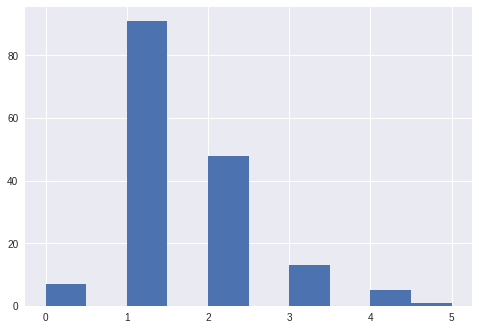

In [114]:
dis_comments = all_df.loc[(all_df['disagreement']==1)&(all_df['agreement']==0),'number_of_ideas']
print(f'There are  {len(dis_comments)} comments with only disagreement. '\
      f'These comments have in average {round(dis_comments.mean(),3)} ideas.')
dis_comments.hist()

### B) Comments that *only* have agreement

There are  132 comments with only agreement. These comments have in average 1.356 ideas.


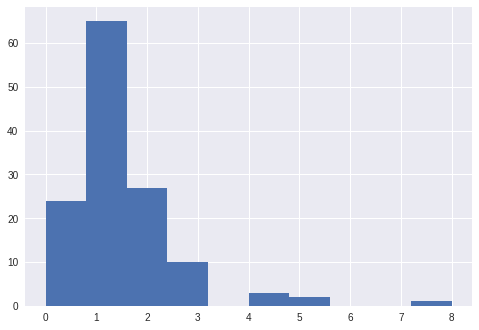

In [115]:
agr_comments = all_df.loc[(all_df['disagreement']==0)&(all_df['agreement']==1),'number_of_ideas']
print(f'There are  {agr_comments.shape[0]} comments with only agreement. '\
      f'These comments have in average {round(agr_comments.mean(), 3)} ideas.')
agr_comments.hist()

### C) Comments with both disagreement and agreement

There are  113 comments with agreement and disagreement. These comments have in average 1.956 ideas.


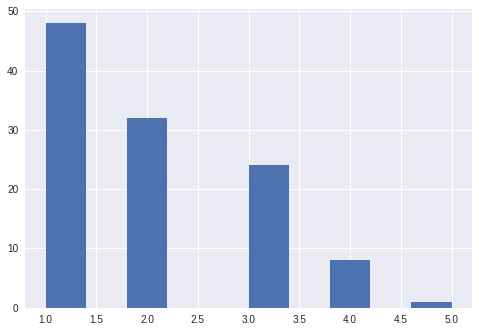

In [117]:
dis_agr_comments = all_df.loc[(all_df['disagreement']==1)&(all_df['agreement']==1), 'number_of_ideas']
print(f'There are  {dis_agr_comments.shape[0]} comments with agreement and disagreement. '\
      f'These comments have in average {round(dis_agr_comments.mean(), 3)} ideas.')
dis_agr_comments.hist()

### D) Comments that don't have disagreement neither agreement

There are 78 comments with neither agreement and disagreement. These comments have in average 1.167 ideas.


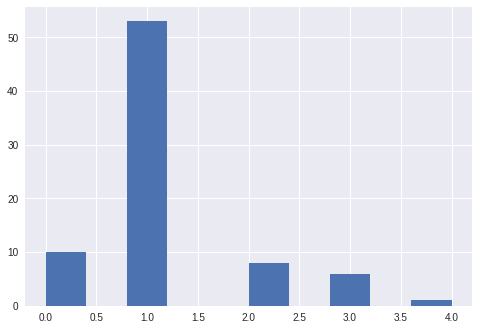

In [118]:
no_dis_agr_comments = all_df.loc[(all_df['disagreement']==0)&(all_df['agreement']==0),'number_of_ideas']
print(f'There are {no_dis_agr_comments.shape[0]} comments with neither agreement and disagreement. '\
      f'These comments have in average {round(no_dis_agr_comments.mean(), 3)} ideas.')
no_dis_agr_comments.hist()

### Difference in the number of ideas

In [133]:
comment_types = [
    {
        'name': 'only disagreement',
        'set': dis_comments,
        'mean_ideas': dis_comments.mean()
    },
    {
        'name': 'only agreement',
        'set': agr_comments,
        'mean_ideas': agr_comments.mean()
    },
    {
        'name': 'disagreement and agreement',
        'set': dis_agr_comments,
        'mean_ideas': dis_agr_comments.mean()
    },
    {
        'name': 'no disagreement neither agreement',
        'set': no_dis_agr_comments,
        'mean_ideas': no_dis_agr_comments.mean()
    }
]

In [136]:
for i in range(len(comment_types)-1):
    for j in range(i+1, len(comment_types)):
        print(f"Checking if the difference in the number of ideas between:\n- comments with {comment_types[i]['name']} "\
              f"and\n- comments with {comment_types[j]['name']}\nis statistically significant")
        stat, p_val = stats.mannwhitneyu(comment_types[i]['set'], comment_types[j]['set'])
        if p_val < alpha_level:
            print(f'The difference between samples is statistically significant, p-value: {round(p_val,4)}.')
            print(f"Mean of ideas {comment_types[i]['name']}: {comment_types[i]['mean_ideas']}")
            print(f"Mean of ideas {comment_types[j]['name']}: {comment_types[j]['mean_ideas']}")
        else:
            print(f'The difference between samples is not statistically significant, p-value: {round(p_val,4)}.')
        print()
    print()

Checking if the difference in the number of ideas between:
- comments with only disagreement and
- comments with only agreement
is statistically significant
The difference between samples is statistically significant, p-value: 0.0089.
Mean of ideas only disagreement: 1.5212121212121212
Mean of ideas only agreement: 1.356060606060606

Checking if the difference in the number of ideas between:
- comments with only disagreement and
- comments with disagreement and agreement
is statistically significant
The difference between samples is statistically significant, p-value: 0.0001.
Mean of ideas only disagreement: 1.5212121212121212
Mean of ideas disagreement and agreement: 1.9557522123893805

Checking if the difference in the number of ideas between:
- comments with only disagreement and
- comments with no disagreement neither agreement
is statistically significant
The difference between samples is statistically significant, p-value: 0.0003.
Mean of ideas only disagreement: 1.52121212121212

Summary 
- Disagreement > agreement
- Disagreement > neither agreement nor disagreement
- Agreement and disagreement > disagreement
- Agreement and disagreement > agreement
- Agreement and disagreement > neither agreement nor disagreement